In [1]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import librosa

from sklearn.metrics import roc_auc_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
import timm

from importlib import reload

logging.basicConfig(level=logging.ERROR)

from module import preprocess_lib, datasets_lib, utils_lib, models_lib, learning_lib, config_lib
reload(config_lib)

<module 'module.config_lib' from '/root/program/birdclef-2025/scripts/module/config_lib.py'>

In [2]:


class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            
            self.spectrogram_npy = '../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy'
            
            self.pseudo_label_csv = "../data/result/pseudo_labels_baseline_7sec.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5.0 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 512
        self.N_MELS = 128
        self.FMIN = 50
        self.FMAX = 14000     
           

        self.seed = 42
        # ===== Training Mode =====
        if mode == "train":
          
            self.apex = False
            self.print_freq = 100
            self.num_workers = 2

            self.LOAD_DATA = True
            self.epochs = 10
            self.batch_size = 516
            self.criterion = 'BCEWithLogitsLoss'

            self.n_fold = 5
            self.selected_folds = [0, 1, 2, 3, 4]

            self.optimizer = 'AdamW'
            self.lr = 5e-4
            self.weight_decay = 1e-5
            self.scheduler = 'CosineAnnealingLR'
            self.min_lr = 1e-6
            self.T_max = self.epochs

            self.aug_prob = 0.5
            self.mixup_alpha_real = 0.5
            self.mixup_alpha_pseudo = 0.5
            
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            self.use_pseudo_mixup = False  # pseudo lableでmixupするかどうか
            self.pseudo_mix_prob = 0.4  # mixupでpseudo lableを使う確率
            self.pseudo_conf_threshold = 0.5
            
        
        

            if self.debug:
                self.epochs = 2
                self.selected_folds = [0]
                self.batch_size = 4
                

In [3]:
# debug trueにするとvalidationの数が1000に固定される．
cfg = CFG(mode="train", kaggle_notebook=False, debug=False)

In [4]:
utils_lib.set_seed(cfg.seed)

In [5]:
spec = np.load("../data/processed/mel_cleaned_0413//birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
train = pd.read_csv("../data/processed/mel_cleaned_0413/train.csv")

In [6]:
train

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,...,1139490-CSA36385,Insecta,center,98.853375,0,7.000000,0,False,1139490-CSA36385,1
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,...,1139490-CSA36389,Insecta,center,96.537719,0,7.000000,0,False,1139490-CSA36389,3
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,...,1192948-CSA36358,Insecta,center,116.599812,0,7.000000,0,False,1192948-CSA36358,0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,...,1192948-CSA36366,Insecta,center,105.446313,0,7.000000,0,False,1192948-CSA36366,1
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,...,1192948-CSA36373,Insecta,center,103.631469,0,7.000000,0,False,1192948-CSA36373,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,...,ywcpar-iNat77392,Aves,center,3.392000,0,3.392000,0,False,ywcpar-iNat77392,3
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,...,ywcpar-iNat78624,Aves,center,7.659688,0,7.659688,0,False,ywcpar-iNat78624,4
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,...,ywcpar-iNat789234,Aves,center,7.666656,0,7.666656,0,False,ywcpar-iNat789234,3
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,...,ywcpar-iNat819873,Aves,center,27.036750,0,27.036750,0,False,ywcpar-iNat819873,1


In [7]:
def compute_combined_loss_df(base_dir, fold_ids=[0, 1, 2, 3, 4]):
    all_loss_dfs = []

    for fold in fold_ids:
        pred_path = os.path.join(base_dir, f"predictions_fold{fold}.csv")
        target_path = os.path.join(base_dir, f"targets_fold{fold}.csv")

        # 読み込み
        predictions = pd.read_csv(pred_path)
        targets = pd.read_csv(target_path)

        row_ids = predictions["row_id"]
        preds = predictions.drop(columns=["row_id"]).values
        true = targets.drop(columns=["row_id"]).values

        # loss計算
        epsilon = 1e-7
        bce = - (true * np.log(preds + epsilon) + (1 - true) * np.log(1 - preds + epsilon))
        sample_loss = bce.mean(axis=1)

        # positiveラベル数
        num_positive = true.sum(axis=1)

        # DataFrame化
        loss_df = pd.DataFrame({
            "row_id": row_ids,
            "sample_loss": sample_loss,
            "num_positive_labels": num_positive,
            "fold": fold
        })

        all_loss_dfs.append(loss_df)

    # 統合
    combined_loss_df = pd.concat(all_loss_dfs, ignore_index=True)
    combined_loss_df = combined_loss_df.sort_values(by="sample_loss", ascending=False).reset_index(drop=True)

    return combined_loss_df


def plot_melspectrogram(spec: dict, species_id: str, 
                        fmin: int = 50, fmax: int = 16000, 
                        duration: float = 5.0,
                        figsize=(6, 4), cmap='magma'):

    if species_id not in spec:
        print(f"[ERROR] '{species_id}' not found in spec!")
        return

    mel = spec[species_id]  # shape: (n_mels, time_steps)
    extent = [0, duration, fmin, fmax]

    plt.figure(figsize=figsize)
    plt.imshow(mel, aspect='auto', origin='lower', cmap=cmap, extent=extent)
    plt.title(f"MelSpectrogram of {species_id}")
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label='Amplitude')
    plt.tight_layout()
    plt.show()

In [8]:
loss_df = compute_combined_loss_df("../models/mel_cleaned0413")
loss_df.head(10)

,row_id,sample_loss,num_positive_labels,fold
0,olipic1/XC561651.ogg,0.256099,6.0,3
1,yebela1/XC913479.ogg,0.204685,5.0,3
2,whtdov/XC703709.ogg,0.175123,10.0,3
3,bubwre1/XC395982.ogg,0.174925,5.0,3
4,paltan1/XC708161.ogg,0.174168,6.0,2
5,blcjay1/XC319947.ogg,0.169229,6.0,0
6,leagre/XC619321.ogg,0.159301,6.0,3
7,mastit1/XC353967.ogg,0.158421,6.0,4
8,ruther1/XC708492.ogg,0.158282,5.0,1
9,ywcpar/XC537086.ogg,0.158232,5.0,3


In [9]:
loss_df[loss_df["row_id"].str.contains("bubwre1")].head(10)

,row_id,sample_loss,num_positive_labels,fold
3,bubwre1/XC395982.ogg,0.174925,5.0,3
30,bubwre1/XC777742.ogg,0.114269,3.0,4
182,bubwre1/XC906410.ogg,0.068256,2.0,3
363,bubwre1/XC286984.ogg,0.054482,3.0,4
400,bubwre1/XC777936.ogg,0.052768,2.0,0
461,bubwre1/XC243820.ogg,0.050257,3.0,0
484,bubwre1/XC695955.ogg,0.049641,4.0,4
526,bubwre1/XC400558.ogg,0.048148,4.0,4
539,bubwre1/XC827255.ogg,0.047856,1.0,1
560,bubwre1/iNat714007.ogg,0.047326,1.0,2


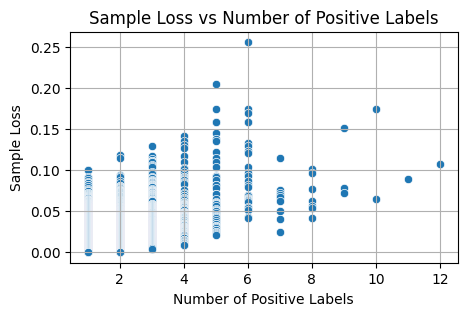

In [10]:
# num_positive_labelsとsample lossの関係をプロット
# labelが多いほうがlossが大きい
plt.figure(figsize=(5, 3))
sns.scatterplot(data=loss_df, x="num_positive_labels", y="sample_loss")
plt.title("Sample Loss vs Number of Positive Labels")
plt.xlabel("Number of Positive Labels")
plt.ylabel("Sample Loss")
plt.grid()
plt.show()

In [11]:
# num_positive_labelsが1のものを抽出
i = 1
hard_filename = loss_df[loss_df["num_positive_labels"] == 1]["row_id"].values[i]
train[train["filename"] == hard_filename]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
18150,shghum1,[''],['song'],shghum1/XC355659.ogg,XC,2.0,https://xeno-canto.org/355659,3.6009,-75.0219,Chrysuronia goudoti,...,shghum1-XC355659,Aves,center,5.12,0,5.12,0,False,shghum1-XC355659,1


In [76]:
label = train[train["filename"] == hard_filename]["primary_label"].values[0]
df = train[train["primary_label"] == label]
print(df.shape)
df.head()

(15, 25)


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
18149,shghum1,[''],['begging call'],shghum1/XC175790.ogg,XC,5.0,https://xeno-canto.org/175790,2.2092,-75.6407,Chrysuronia goudoti,...,shghum1-XC175790,Aves,center,53.211438,0,53.211438,0,False,shghum1-XC175790,0
18150,shghum1,[''],['song'],shghum1/XC355659.ogg,XC,2.0,https://xeno-canto.org/355659,3.6009,-75.0219,Chrysuronia goudoti,...,shghum1-XC355659,Aves,center,5.120000,0,5.120000,0,False,shghum1-XC355659,1
18151,shghum1,[''],['song'],shghum1/XC401434.ogg,XC,3.0,https://xeno-canto.org/401434,4.6768,-74.8200,Chrysuronia goudoti,...,shghum1-XC401434,Aves,center,46.524094,0,46.524094,0,False,shghum1-XC401434,4
18152,shghum1,[''],['call'],shghum1/XC424725.ogg,XC,5.0,https://xeno-canto.org/424725,4.4483,-75.1625,Chrysuronia goudoti,...,shghum1-XC424725,Aves,center,40.056000,0,40.056000,0,False,shghum1-XC424725,4
18153,shghum1,[''],"['call', 'flight call']",shghum1/XC544035.ogg,XC,4.0,https://xeno-canto.org/544035,4.3510,-74.6520,Chrysuronia goudoti,...,shghum1-XC544035,Aves,center,6.243250,0,6.243250,0,False,shghum1-XC544035,3


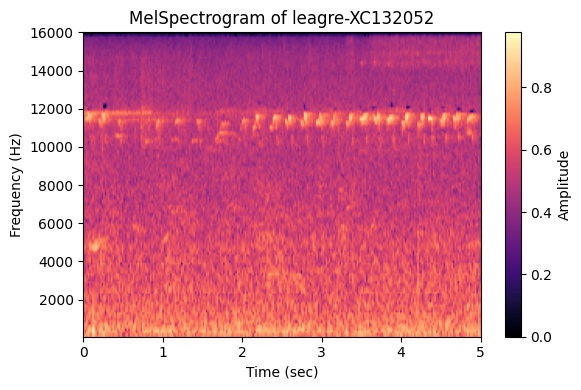

In [71]:
filename = "leagre/XC132052.ogg"
samplename= train[train["filename"] == filename]["samplename"].values[0]
# 表示
plot_melspectrogram(spec, samplename)
utils_lib.play_audio(filename, cfg.train_datadir)

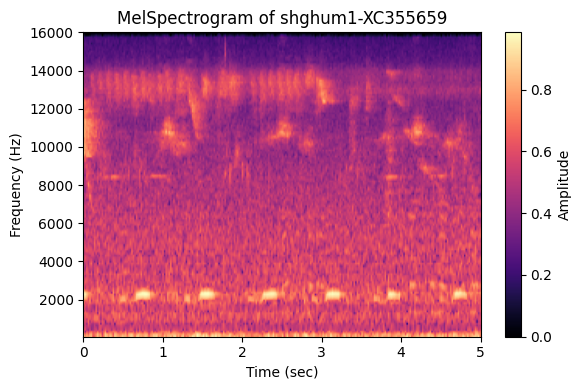

filename: shghum1/XC355659.ogg
species_id: shghum1-XC355659
label: shghum1


In [78]:
# 表示したい species_id を指定（例: 'pitangsp'）
samplename= train[train["filename"] == hard_filename]["samplename"].values[0]
# 表示
plot_melspectrogram(spec, samplename)

print(f"filename: {hard_filename}")
print(f"species_id: {samplename}")
print(f"label: {label}")
utils_lib.play_audio(hard_filename, cfg.train_datadir)

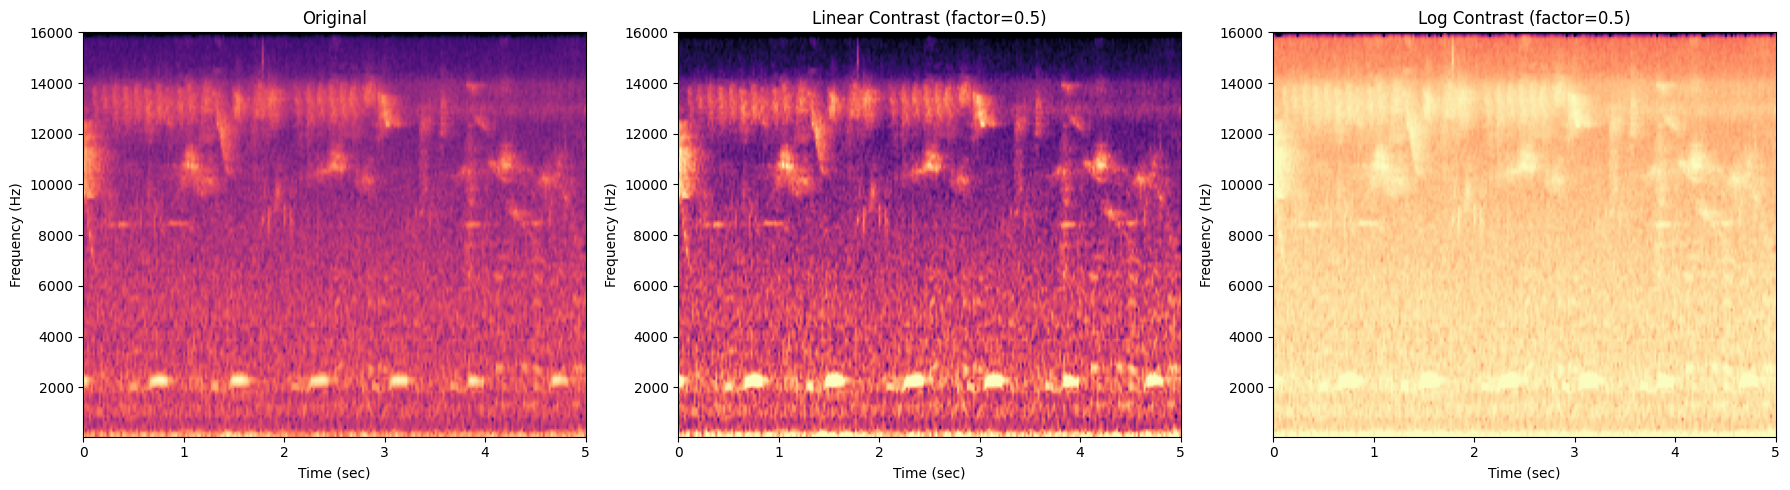

In [80]:

def enhance_spectrogram_contrast_linear(spec, factor=0.15):
    """
    線形のコントラスト強調：meanとの差分を拡張
    """
    mean = np.mean(spec)
    enhanced = mean + (spec - mean) * (1 + factor)
    return np.clip(enhanced, 0, 1)

def enhance_spectrogram_contrast_log_safe(spec, factor=0.15):
    """
    より安定した log スケーリング + コントラスト強調
    """
    log_spec = np.log10(spec + 1e-6)

    # コントラスト強調（平均中心化）
    mean = np.mean(log_spec)
    enhanced = mean + (log_spec - mean) * (1 + factor)

    # 実用的な表示のために [-3, 0] の範囲を前提に正規化（適宜調整可）
    normalized = (enhanced + 3) / 3  # [-3, 0] → [0, 1]

    return np.clip(normalized, 0, 1)

def show_spectrogram_contrast_comparison(spec, factor=0.15, log_base=10, fmin=50, fmax=16000, duration=5.0):
    """
    オリジナル / 線形強調 / log強調 の比較表示
    """
    extent = [0, duration, fmin, fmax]

    enhanced_linear = enhance_spectrogram_contrast_linear(spec, factor)
    enhanced_log = enhance_spectrogram_contrast_log_safe(spec, factor)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    axs[0].imshow(spec, aspect='auto', origin='lower', cmap='magma', extent=extent)
    axs[0].set_title("Original")
    
    axs[1].imshow(enhanced_linear, aspect='auto', origin='lower', cmap='magma', extent=extent)
    axs[1].set_title(f"Linear Contrast (factor={factor})")

    axs[2].imshow(enhanced_log, aspect='auto', origin='lower', cmap='magma', extent=extent)
    axs[2].set_title(f"Log Contrast (factor={factor})")

    for ax in axs:
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("Frequency (Hz)")
    
    plt.tight_layout()
    plt.show()
    
species_id = "shghum1-XC355659"
mel = spec[species_id]
show_spectrogram_contrast_comparison(mel, factor=0.5)


In [11]:
log_0413 = pd.read_csv("../models/fold0_mel_cleaned0413/log_fold0.csv")
log_0413_check = pd.read_csv("../models/training_0420_ihira/log_fold0.csv")

In [13]:
log_0413

,epoch,lr,epoch_time_min,train_loss,train_auc,train_map,val_loss,val_auc,val_map
0,1,0.000488,0.83,0.036685,0.597111,0.011635,0.025884,0.801365,0.075796
1,2,0.000452,0.84,0.023150,0.818738,0.101754,0.019880,0.902546,0.260424
2,3,0.000397,0.68,0.018891,0.901719,0.216222,0.017477,0.929269,0.359200
3,4,0.000328,1.03,0.016228,0.939691,0.313761,0.016325,0.943191,0.436400
4,5,0.000251,0.83,0.014046,0.959882,0.411800,0.015657,0.947512,0.478556
5,6,0.000173,0.85,0.011979,0.977128,0.505733,0.015190,0.949670,0.506400
6,7,0.000104,0.66,0.010183,0.984572,0.593013,0.015276,0.948696,0.520986
7,8,0.000049,0.67,0.008583,0.990933,0.675132,0.015441,0.947273,0.527649
8,9,0.000013,0.99,0.007443,0.994008,0.742257,0.015411,0.946701,0.536358
9,10,0.000001,0.67,0.006943,0.994722,0.775941,0.015491,0.946169,0.531970


In [14]:
log_0413_check

,epoch,lr,epoch_time_min,train_loss,train_auc,train_map,val_loss,val_auc,val_map
0,1,0.000488,2.07,0.036684,0.597055,0.011663,0.025879,0.801008,0.076346
1,2,0.000452,1.88,0.023134,0.818725,0.102453,0.019890,0.902681,0.259659
2,3,0.000397,2.05,0.018869,0.902393,0.217739,0.017491,0.930386,0.363642
3,4,0.000328,2.05,0.016216,0.939768,0.314454,0.016371,0.942187,0.432748
4,5,0.000251,1.88,0.014035,0.959801,0.412294,0.015616,0.947067,0.477223
5,6,0.000173,2.05,0.011961,0.976630,0.504542,0.015235,0.949096,0.497432
6,7,0.000104,1.88,0.010150,0.984656,0.596730,0.015293,0.947801,0.521255
7,8,0.000049,2.05,0.008554,0.990994,0.679759,0.015417,0.946540,0.532778
8,9,0.000013,2.04,0.007439,0.993982,0.744905,0.015471,0.945829,0.537126
9,10,0.000001,1.88,0.006915,0.994766,0.778047,0.015550,0.945294,0.532000


In [12]:
df = pd.DataFrame()
df["val_auc"] = log_0413["val_auc"].copy()
df["val_auc_check"] = log_0413_check["val_auc"].copy()

df

,val_auc,val_auc_check
0,0.801365,0.801008
1,0.902546,0.902681
2,0.929269,0.930386
3,0.943191,0.942187
4,0.947512,0.947067
5,0.949670,0.949096
6,0.948696,0.947801
7,0.947273,0.946540
8,0.946701,0.945829
9,0.946169,0.945294


In [15]:
model_0413_path = "../models/fold0_mel_cleaned0413_vino/model_fold0.xml"
model_0420_path = "../models/models_0420_vino/model_fold0.xml"

In [ ]:
import numpy as np
from openvino.runtime import Core

# モデルのパス
model_0413_path = "../models/fold0_mel_cleaned0419_2_vino/model_fold0.xml"
model_0420_path = "../models/models_"

# OpenVINO Core 初期化
core = Core()

# モデル読み込み
compiled_model_0413 = core.compile_model(model=model_0413_path, device_name="CPU")
compiled_model_0420 = core.compile_model(model=model_0420_path, device_name="CPU")

# 推論リクエスト用インスタンス
infer_0413 = compiled_model_0413.create_infer_request()
infer_0420 = compiled_model_0420.create_infer_request()

# 入力名の確認（ONNXからの変換によって名前が異なる場合がある）
input_name_0413 = compiled_model_0413.input(0).get_any_name()
input_name_0420 = compiled_model_0420.input(0).get_any_name()

# ダミー入力（実際のspectrogramと同じshapeに合わせる）
input_data = np.random.rand(1, 1, 256, 256).astype(np.float32)

# 推論実行
output_0413 = infer_0413.infer({input_name_0413: input_data})
output_0420 = infer_0420.infer({input_name_0420: input_data})

# 出力取得
output_0413 = list(output_0413.values())[0]
output_0420 = list(output_0420.values())[0]

# 差分確認
abs_diff = np.abs(output_0413 - output_0420)
print("🔍 出力比較:")
print(f"最大誤差: {np.max(abs_diff)}")
print(f"平均誤差: {np.mean(abs_diff)}")
print(f"標準偏差: {np.std(abs_diff)}")

/opt/conda/lib/python3.10/importlib/util.py:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  self.__spec__.loader.exec_module(self)


🔍 出力比較:
最大誤差: 9.62890625
平均誤差: 5.529012203216553
標準偏差: 1.6940476894378662


In [19]:
model_0413_path = "../models/fold0_mel_cleaned0413/model_fold0.pth"
model_0420_path = "../models/training_0420_ihira/model_fold0.pth"

In [25]:
import torch
import numpy as np

from module import models_lib
from module.utils_lib import set_seed

# モデルパス
model_0413_path = "../models/fold0_mel_cleaned0413/model_fold0.pth"
model_0420_path = "../models/training_0420_ihira/model_fold0.pth"

# 共通設定（このCFGは必須）
cfg = CFG(mode="inference", kaggle_notebook=False)
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
num_classes = len(taxonomy_df['primary_label'].tolist())


# モデル読み込み関数
def load_model(path):
    model = models_lib.BirdCLEFModelForInference(cfg, num_classes)
    checkpoint = torch.load(path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

# モデル読み込み
model_0413 = load_model(model_0413_path)
model_0420 = load_model(model_0420_path)

# 同じダミー入力
dummy_input = torch.randn(1, 1, 256, 256)

# 推論（出力に sigmoid が必要な場合は model に含まれてるか確認して適宜追加）
with torch.no_grad():
    out_0413 = model_0413(dummy_input).numpy()
    out_0420 = model_0420(dummy_input).numpy()

# 差分計算
abs_diff = np.abs(out_0413 - out_0420)
print("🔍 PyTorch モデル出力比較:")
print(f"最大誤差: {np.max(abs_diff)}")
print(f"平均誤差: {np.mean(abs_diff)}")
print(f"標準偏差: {np.std(abs_diff)}")

🔍 PyTorch モデル出力比較:
最大誤差: 3.029848098754883
平均誤差: 1.068826675415039
標準偏差: 0.7281784415245056


In [27]:
out_0413[0]

array([ -9.195662  ,  -9.994078  , -11.393284  , -12.521665  ,
        -8.837736  , -11.523256  ,  -5.987206  ,  -8.571722  ,
        -9.11408   ,  -8.987062  , -10.955479  ,  -8.993287  ,
       -11.88201   , -10.775237  , -13.205208  , -10.291743  ,
       -11.978032  , -13.025007  , -13.344963  ,  -0.46550336,
       -12.066053  , -12.601817  ,  -4.390723  , -11.455728  ,
       -10.015752  , -12.110594  , -10.06635   , -12.822595  ,
       -12.051105  ,  -7.682321  ,  -7.6940517 , -10.249572  ,
        -9.190001  , -12.941129  , -11.314352  ,  -9.115991  ,
       -13.124766  , -11.400146  , -13.89875   , -12.027119  ,
       -12.277826  , -10.337521  , -15.516044  , -12.150939  ,
       -12.58441   , -12.583952  , -12.954168  , -11.418587  ,
       -10.562248  , -11.7546015 , -11.661776  , -14.000616  ,
       -11.679147  , -10.548455  , -11.812361  , -11.758138  ,
       -12.179669  , -11.062965  , -10.054097  ,  -8.642231  ,
       -10.081915  ,  -2.8448334 , -13.212624  ,  -5.76

In [28]:
out_0420[0]

array([ -8.881583  ,  -9.76702   , -10.810332  , -10.319734  ,
        -8.484443  , -10.324937  ,  -6.924858  ,  -8.564739  ,
        -8.779279  ,  -8.761365  , -10.07584   ,  -7.795031  ,
       -11.181228  , -10.377627  , -10.307871  ,  -7.8092723 ,
       -10.150643  , -10.559597  , -10.536683  ,  -1.0621634 ,
       -10.541391  , -11.600967  ,  -5.5721636 , -10.989717  ,
        -9.044543  , -10.924361  ,  -9.630425  , -11.850575  ,
       -10.44597   ,  -7.9491377 ,  -7.02836   ,  -7.5852637 ,
        -8.725544  , -11.637092  , -10.744624  ,  -9.279085  ,
       -12.080761  ,  -9.357077  , -12.649784  , -10.811234  ,
       -10.370738  ,  -9.324203  , -13.542844  ,  -9.563347  ,
       -11.861518  ,  -9.836335  , -11.563377  , -10.858316  ,
        -9.2670965 , -10.590236  , -10.597139  , -12.192073  ,
       -10.915604  ,  -9.948999  , -10.813131  , -10.715941  ,
       -11.010016  ,  -9.31271   ,  -9.612187  ,  -9.284879  ,
        -7.4054794 ,  -3.151105  , -12.318355  ,  -3.45

In [65]:
log_0413 = pd.read_csv("../models/fold0_mel_cleaned0413/log_fold0.csv")
log_0419_2 = pd.read_csv("../models/fold0_mel_cleaned0419_2/log_fold0.csv")

df = pd.DataFrame()
df["val_auc"] = log_0413["val_auc"].copy()
df["val_auc_0419_2"] = log_0419_2["val_auc"].copy()

df

,val_auc,val_auc_0419_2
0,0.801365,0.801921
1,0.902546,0.901664
2,0.929269,0.929767
3,0.943191,0.943422
4,0.947512,0.946894
5,0.949670,0.950530
6,0.948696,0.950711
7,0.947273,0.948614
8,0.946701,0.947690
9,0.946169,0.947524


In [57]:
score_0413 = pd.read_csv("../models/fold0_mel_cleaned0413/best_val_classwise_score_fold0.csv")
socre_check2 = pd.read_csv("../models/fold0_cleaned0413_check2/best_val_classwise_score_fold0.csv")

# 一致しているか確認
df = pd.DataFrame()
df["score_0413"] = score_0413["val_auc"].copy()
df["score_check2"] = socre_check2["val_auc"].copy()
len(df[df["score_0413"] == df["score_check2"]]) == len(df)


True

In [ ]:
# predictionsも一致
predictions_0413 = pd.read_csv("../models/fold0_mel_cleaned0413/predictions_fold0.csv")
predictions_check2 = pd.read_csv("../models/fold0_cleaned0413_check2/predictions_fold0.csv")

# まず row_id をソートして整列（行の順序が一致しない可能性に備えて）
pred1 = predictions_0413.sort_values("row_id").reset_index(drop=True)
pred2 = predictions_check2.sort_values("row_id").reset_index(drop=True)

# 形状の一致確認
if pred1.shape != pred2.shape:
    print(f"形状が一致しません: {pred1.shape} vs {pred2.shape}")
else:
    # DataFrame全体の一致（完全一致）
    is_equal = pred1.equals(pred2)
    print(f"完全一致するか？: {is_equal}")

    # 数値的な誤差も含めて確認（浮動小数点誤差を許容）
    numerical_part1 = pred1.drop(columns=["row_id"]).astype(float)
    numerical_part2 = pred2.drop(columns=["row_id"]).astype(float)

    is_allclose = np.allclose(numerical_part1.values, numerical_part2.values, atol=1e-6)
    print(f"誤差1e-6以内で一致するか？: {is_allclose}")

完全一致するか？: True
誤差1e-6以内で一致するか？: True


In [15]:
spec_0413 = np.load("../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
spec_0413_check = np.load("../data/processed/dataset-0419/melspec_20250419_1808/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()

In [25]:
import numpy as np
# データセットは一致．

# 共通のキーを取得
common_keys = set(spec_0413.keys()) & set(spec_0413_check.keys())
print(f"共通のキーの数: {len(common_keys)}")

# 結果格納用
different_keys = []

for key in common_keys:
    value1 = spec_0413[key]
    value2 = spec_0413_check[key]

    if not np.array_equal(value1, value2):
        # 完全一致していない場合
        if np.allclose(value1, value2, atol=1e-6):
            # 誤差の範囲で一致している
            continue
        else:
            # 明確に異なるキー
            different_keys.append(key)
            diff = np.abs(value1 - value2)
            print(f"[差分あり] キー: {key}")
            print(f"  - shape: {value1.shape} vs {value2.shape}")
            print(f"  - 最大差分: {diff.max():.6f}")
            print(f"  - 平均差分: {diff.mean():.6f}")

if not different_keys:
    print("すべての共通キーにおいて、値は一致（または誤差の範囲内）していました。")
else:
    print(f"{len(different_keys)} 個のキーで明確な差分がありました。")

共通のキーの数: 28564
すべての共通キーにおいて、値は一致（または誤差の範囲内）していました。


In [32]:
train_0413 = pd.read_csv("../data/processed/mel_cleaned_0413/train.csv")
train_0413_check = pd.read_csv("../data/processed/dataset-0419/melspec_20250419_1808//train.csv")

# 比較対象の列を指定
cols_to_check = ['primary_label', 'filename', 'fold']

# 対象列だけ抜き出して比較
subset_0413 = train_0413[cols_to_check].reset_index(drop=True)
subset_0419 = train_0413_check[cols_to_check].reset_index(drop=True)

# 行数・順序が同じなら、以下で比較できる
diff_mask = subset_0413 != subset_0419
rows_with_diff = diff_mask.any(axis=1)

# 差分の行を抽出して表示
diff_rows = pd.concat([
    subset_0413[rows_with_diff].add_prefix("0413_"),
    subset_0419[rows_with_diff].add_prefix("0419_")
], axis=1)


diff_rows

,0413_primary_label,0413_filename,0413_fold,0419_primary_label,0419_filename,0419_fold
0,1139490,1139490/CSA36385.ogg,1,1139490,1139490/CSA36385.ogg,0
1,1139490,1139490/CSA36389.ogg,3,1139490,1139490/CSA36389.ogg,1
2,1192948,1192948/CSA36358.ogg,0,1192948,1192948/CSA36358.ogg,2
3,1192948,1192948/CSA36366.ogg,1,1192948,1192948/CSA36366.ogg,3
4,1192948,1192948/CSA36373.ogg,3,1192948,1192948/CSA36373.ogg,4
...,...,...,...,...,...,...
28559,ywcpar,ywcpar/iNat77392.ogg,3,ywcpar,ywcpar/iNat77392.ogg,0
28560,ywcpar,ywcpar/iNat78624.ogg,4,ywcpar,ywcpar/iNat78624.ogg,2
28561,ywcpar,ywcpar/iNat789234.ogg,3,ywcpar,ywcpar/iNat789234.ogg,2
28562,ywcpar,ywcpar/iNat819873.ogg,1,ywcpar,ywcpar/iNat819873.ogg,3


In [22]:
spec_0413["1139490-CSA36385"]

array([[1.7118777e-04, 2.0463347e-01, 2.1627998e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.4685783e-01],
       [1.2166925e-02, 2.2783673e-01, 2.3946418e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.4746909e-01],
       [3.1053832e-02, 2.6436949e-01, 2.7596697e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.4843149e-01],
       ...,
       [4.1276175e-01, 5.0868046e-01, 4.8000607e-01, ..., 4.6040016e-01,
        4.7328359e-01, 4.6689528e-01],
       [2.2843847e-01, 1.9758661e-01, 1.8644863e-01, ..., 1.7883313e-01,
        1.8383743e-01, 1.8558300e-01],
       [1.1136827e-01, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 6.9116955e-03]], dtype=float32)

In [23]:
spec_0413_check["1139490-CSA36385"]

array([[1.71187785e-04, 2.04633385e-01, 2.16279909e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.46857738e-01],
       [1.21668866e-02, 2.27836654e-01, 2.39464134e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.47468999e-01],
       [3.10537331e-02, 2.64369428e-01, 2.75966972e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.48431405e-01],
       ...,
       [4.12761807e-01, 5.08680403e-01, 4.80006009e-01, ...,
        4.60400105e-01, 4.73283648e-01, 4.66895223e-01],
       [2.28438497e-01, 1.97586596e-01, 1.86448619e-01, ...,
        1.78833097e-01, 1.83837458e-01, 1.85582981e-01],
       [1.11368276e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.91169640e-03]], dtype=float32)

In [ ]:
# 信頼性がない予測値

from scipy.stats import entropy
import numpy as np
import pandas as pd

# row_id を取り出す
row_ids = predictions["row_id"]

# 確率値を NumPy array に
preds = predictions.drop(columns=["row_id"]).values

# --- ① max confidence (自信のあるラベルがないサンプルを検出)
max_confidence = preds.max(axis=1)  # 各サンプルで最大の予測値

# --- ② エントロピー（曖昧さの指標）
entropy_scores = entropy(preds, axis=1)  # axis=1 → 各サンプルごとにエントロピー計算

# --- 結果をまとめる
uncertainty_df = pd.DataFrame({
    "row_id": row_ids,
    "max_confidence": max_confidence,
    "entropy": entropy_scores
})

# 確信度が低い順（曖昧な順）に並べ替え
uncertainty_df = uncertainty_df.sort_values(by="max_confidence", ascending=True).reset_index(drop=True)


,row_id,max_confidence,entropy
0,cattyr/XC318581.ogg,0.029015,4.246751
1,cocwoo1/XC338418.ogg,0.029494,2.734630
2,bicwre1/XC152232.ogg,0.032167,3.291070
3,41663/iNat722167.ogg,0.032939,3.224321
4,shtfly1/XC830340.ogg,0.034673,3.865061
5,50186/CSA20037.ogg,0.034756,4.089189
6,whtdov/XC257620.ogg,0.035642,3.686739
7,bobfly1/XC549946.ogg,0.037735,4.253721
8,strcuc1/iNat332901.ogg,0.037770,4.361690
9,yeofly1/XC120031.ogg,0.039142,4.516472


In [158]:
i = 6
hard_filename = uncertainty_df["row_id"].values[i]
train[train["filename"] == hard_filename]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
25425,whtdov,[''],['song'],whtdov/XC257620.ogg,XC,5.0,https://xeno-canto.org/257620,-0.504,-76.406,Leptotila verreauxi,...,whtdov-XC257620,Aves,center,16.561625,0,16.561625,0,False,whtdov-XC257620,1


In [159]:
label = train[train["filename"] == hard_filename]["primary_label"].values[0]
train[train["primary_label"] == label].shape

(572, 25)

In [160]:
utils_lib.play_audio(hard_filename, cfg.train_datadir)

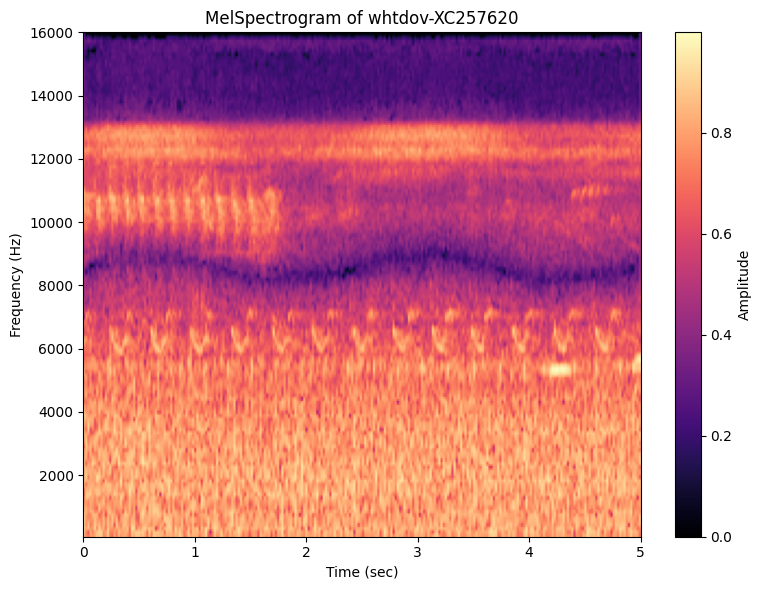

In [161]:


# 表示したい species_id を指定（例: 'pitangsp'）
samplename= train[train["filename"] == hard_filename]["samplename"].values[0]
species_id = samplename # 実際のIDに置き換えてください

# Melスペクトログラムを取得
mel = spec[species_id]  # shape: (256, 256)

n_mels = 148  # 例: 256
fmin = 50           # 実際に使用したfmin
fmax = 16000           # 実際に使用したfmax
duration = 5.0         # メルスペクトログラムの時間（秒）

# X軸（時間）と Y軸（周波数）の範囲指定
extent = [0, duration, fmin, fmax]  # [x_min, x_max, y_min, y_max]

# 表示
plt.figure(figsize=(8, 6))
plt.imshow(mel, aspect='auto', origin='lower', cmap='magma', extent=extent)
plt.title(f"MelSpectrogram of {species_id}")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()